In [1]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf

# Parameters 
n = 100 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'GOOG','WMT', 'CMG', 'XOM']

In [2]:
# Scrape Data from FinViz using BeautifulSoup
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {} #create empty dictionary

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) #request data from the URL #header allows us to have access
    response = urlopen(req)    #beautiful soup can take this in and parse data out of
    html = BeautifulSoup(response, features="lxml") #pass the response through Beautiful Soup
    news_table = html.find(id='news-table') #all articles are located in a table- see id in HTML code from website
    news_tables[ticker] = news_table #ticker is the key to the dictionary 

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Apple Accused of Power Grab at Senate Hearing on App Stores ( Apr-21-21 08:45PM )
Dow Jones Futures: Stock Market Rally Rebounds, Bitcoin Plays Tesla, Square Find Support; Chipotle, Lam Research Top Views Late ( 08:29PM )
Is Peloton Stock A Buy Amid Treadmill Safety Concerns? ( 08:00PM )
Apple and Google failing to keep underage users away from dating apps, says Tinder ( 06:14PM )
Two Companies Will Reach $2 Trillion Next (Tesla Isn't One) ( 05:13PM )
Let's Take A Look At This Weeks Top Performing Sectors ( 05:01PM )
Encrypted chat app Signal reveals flaws in Cellebrite equipment ( 04:39PM )
Pete Najarian Says Goldman Sachs Is Wrong About Apple ( 04:33PM )
Encrypted chat app Signal reveals flaws in Cellebrite equipment ( 04:28PM )
Intel Wins Patent Trial Over Chips, Dodging $1 Billion-Plus Blow ( 04:10PM )
Why analysts are bullish on Apple stock ( 04:09PM )
Apples iPad Pro is making its own laptops obsolete ( 03:55PM )
Senate hearing on app stores put

In [3]:
# Format the Data for Sentiment Analysis by iterating through collected news and sorting into list with tickers, dates, times, and headlines
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1: #implies that we only have timestamp
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
    
print(parsed_news)

[['AAPL', 'Apr-21-21', '08:45PM', 'Apple Accused of Power Grab at Senate Hearing on App Stores'], ['AAPL', 'Apr-21-21', '08:29PM', 'Dow Jones Futures: Stock Market Rally Rebounds, Bitcoin Plays Tesla, Square Find Support; Chipotle, Lam Research Top Views Late'], ['AAPL', 'Apr-21-21', '08:00PM', 'Is Peloton Stock A Buy Amid Treadmill Safety Concerns?'], ['AAPL', 'Apr-21-21', '06:14PM', 'Apple and Google failing to keep underage users away from dating apps, says Tinder'], ['AAPL', 'Apr-21-21', '05:13PM', "Two Companies Will Reach $2 Trillion Next (Tesla Isn't One)"], ['AAPL', 'Apr-21-21', '05:01PM', "Let's Take A Look At This Weeks Top Performing Sectors"], ['AAPL', 'Apr-21-21', '04:39PM', 'Encrypted chat app Signal reveals flaws in Cellebrite equipment'], ['AAPL', 'Apr-21-21', '04:33PM', 'Pete Najarian Says Goldman Sachs Is Wrong About Apple'], ['AAPL', 'Apr-21-21', '04:28PM', 'Encrypted chat app Signal reveals flaws in Cellebrite equipment'], ['AAPL', 'Apr-21-21', '04:10PM', 'Intel Win

In [6]:
# Sentiment Analysis with NLTK VADER Sentiment
vader = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns) #create dataframe to host data

f = lambda Headline: vader.polarity_scores(Headline)['compound']
news['compound'] = news['Headline'].apply(f)
#scores = news['Headline'].apply(vader.polarity_scores).tolist()
news.head()
# df_scores = pd.DataFrame(scores)
# news = news.join(df_scores, rsuffix='_right')
# news.head()


,Ticker,Date,Time,Headline,compound
0,AAPL,Apr-21-21,08:45PM,Apple Accused of Power Grab at Senate Hearing ...,-0.2960
1,AAPL,Apr-21-21,08:29PM,Dow Jones Futures: Stock Market Rally Rebounds...,0.6705
2,AAPL,Apr-21-21,08:00PM,Is Peloton Stock A Buy Amid Treadmill Safety C...,0.4215
3,AAPL,Apr-21-21,06:14PM,Apple and Google failing to keep underage user...,-0.5106
4,AAPL,Apr-21-21,05:13PM,Two Companies Will Reach $2 Trillion Next (Tes...,0.0258


<Figure size 1800x720 with 0 Axes>

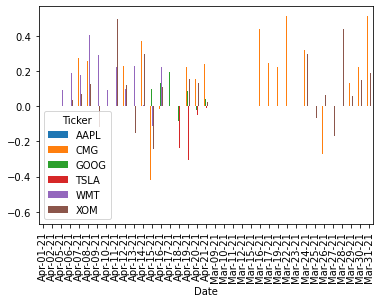

<Figure size 1800x720 with 0 Axes>

In [7]:
#Manipulate the Data in order to create a plot
mean_news= news.groupby(['Ticker', 'Date']).mean() 
mean_news = mean_news.unstack() #need the date as x axis
mean_news = mean_news.xs('compound', axis= 'columns').transpose() 
mean_news.plot(kind='bar')
plt.figure(figsize=(25,10))

In [8]:
#testing VADER
print(vader.polarity_scores('Apple is the worst company ever'))

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [9]:
#testing VADER
print(vader.polarity_scores('Apple is a bad company and will fail'))

{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.7906}


In [10]:
#testing VADER
print(vader.polarity_scores('Apple is a great company and will fail'))

{'neg': 0.278, 'neu': 0.397, 'pos': 0.325, 'compound': 0.1531}


In [11]:
#RNN LSTM MODEL

# Pre-Processing for RNN input
# Create Feature and Label sets
# Creating the X and y vectors
X = news["Headline"].values
y = news["compound"].values

In [12]:
# Import Keras modules for data encoding #encode data as integer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [14]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'to', token: 1
word: 'in', token: 2
word: 'apple', token: 3
word: 'and', token: 4
word: 'the', token: 5


In [15]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})
print("**Numerical sequence representation**")
print(X_seq[0])

**Text comment**
{'Apple Accused of Power Grab at Senate Hearing on App Stores'}
**Numerical sequence representation**
[3, 542, 6, 161, 543, 28, 196, 197, 7, 76, 95]


In [16]:
# Padding sequences
X_pad = pad_sequences(X_seq, maxlen=140, padding="post")

In [17]:
X_pad

array([[   3,  542,    6, ...,    0,    0,    0],
       [  31,   38,  117, ...,    0,    0,    0],
       [  12,  544,   13, ...,    0,    0,    0],
       ...,
       [ 536,  295, 1910, ...,    0,    0,    0],
       [ 176,  342, 1914, ...,    0,    0,    0],
       [  37,  136,  295, ...,    0,    0,    0]], dtype=int32)

In [18]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, random_state=78)

In [19]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [20]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
max_words = 140
embedding_size = 64

In [21]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [22]:
# # Compile the model
# model.compile(
#     loss="binary_crossentropy",
#     optimizer="adam"
# )
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [23]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           122560    
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 509,241
Trainable params: 509,241
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Training the model
batch_size = 1000
model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.6905 - accuracy: 0.4711 - tp: 0.0000e+00 - tn: 212.0000 - fp: 0.0000e+00 - fn: 238.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 0.6406 - accuracy: 0.4711 - tp: 0.0000e+00 - tn: 212.0000 - fp: 0.0000e+00 - fn: 238.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 0.5837 - accuracy: 0.4711 - tp: 0.0000e+00 - tn: 212.0000 - fp: 0.0000e+00 - fn: 238.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 0.4993 - accuracy: 0.4711 - tp: 0.0000e+00 - tn: 212.0000 - fp: 0.0000e+00 - fn: 238.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.3261 - accuracy: 0.4711 - tp: 0.0000e+00 - tn: 212.0000 -

In [25]:
#evaluate the model
model.evaluate(X_test, y_test)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

5/5 [==============================] - 2s 76ms/step - loss: 0.2699 - accuracy: 0.4533 - tp: 0.0000e+00 - tn: 68.0000 - fp: 0.0000e+00 - fn: 82.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


NameError: name 'score' is not defined

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score

print("RNN LSTM Accuracy %.2f" % (accuracy_score(X_test, y_test)))

In [ ]:
# Make sentiment predictions #predict using testing data and model
predicted = (model.predict(X_test[:10])>0.5).astype("int32")

In [ ]:
#compares the actual text from original dataframe to the predicted values
_, X_test_original, _, _ = train_test_split(X, y, random_state=42)

In [ ]:
# Create a DataFrame of Real and Predicted values
sentiments = pd.DataFrame({"Text": X_test_original[:10], "Actual": y_test[:10], "Predicted": predicted2.ravel()})
sentiments

In [ ]:
sentiments.plot()

In [ ]:
#